<a href="https://www.kaggle.com/code/aisuko/text-to-video-with-animatediff?scriptVersionId=164608032" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

AnimateDiff is a modelling framework that allows you to create videos using pre-existing Stable Diffusion text-to-image models. It achieves this by inserting motion module layers into a frozen text-to-image model and training it on video clips to extract a motion prior.

These motion modules are applied after the ResNet and Attention blocks in the Stable Diffusion UNet. Their purpose is to introduce coherent motion across image frames. To support these modules, `diffusers` introduce the concepts of a `MotionAdapter` and a `UNetMotionModel`. These serve as a convenient way to use these motion modules with existing Stable Diffusion Models. The following example demonstrates how you can utilize the motion modules with an existing Stable Diffusion text-to-image model.

In [1]:
%%capture
!pip install diffusers==0.23.1

# Loading Models

In [2]:
import torch

from diffusers import MotionAdapter, AnimateDiffPipeline, DDIMScheduler
from diffusers.utils import export_to_gif

# Load the motion adapter
adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2")

# load SD 1.5 based finetuned model
model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
pipe = AnimateDiffPipeline.from_pretrained(model_id, motion_adapter=adapter)
pipe.load_lora_weights("guoyww/animatediff-motion-lora-zoom-out", adapter_name="zoom-out")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The config attributes {'motion_activation_fn': 'geglu', 'motion_attention_bias': False, 'motion_cross_attention_dim': None} were passed to MotionAdapter, but are not expected and will be ignored. Please verify your config.json configuration file.


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

The config attributes {'center_input_sample': False, 'flip_sin_to_cos': True, 'freq_shift': 0, 'mid_block_type': 'UNetMidBlock2DCrossAttn', 'only_cross_attention': False, 'encoder_hid_dim': None, 'attention_head_dim': 8, 'dual_cross_attention': False, 'class_embed_type': None, 'addition_embed_type': None, 'num_class_embeds': None, 'upcast_attention': False, 'resnet_time_scale_shift': 'default', 'resnet_skip_time_act': False, 'resnet_out_scale_factor': 1.0, 'time_embedding_type': 'positional', 'time_embedding_dim': None, 'time_embedding_act_fn': None, 'timestep_post_act': None, 'time_cond_proj_dim': None, 'conv_in_kernel': 3, 'conv_out_kernel': 3, 'projection_class_embeddings_input_dim': None, 'class_embeddings_concat': False, 'mid_block_only_cross_attention': None, 'cross_attention_norm': None, 'addition_embed_type_num_heads': 64} were passed to UNetMotionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


# Loading Scheduler

In [3]:
scheduler = DDIMScheduler.from_pretrained(
    model_id, subfolder="scheduler", clip_sample=False, timestep_spacing="linspace", steps_offset=1
)
pipe.scheduler = scheduler
pipe.to('cuda')

# enable memory savings
pipe.enable_vae_slicing()
pipe.enable_model_cpu_offload()

In [4]:
output=pipe(
    prompt=(
        "masterpiece, bestquality, highlydetailed, ultradetrailed, sunset, "
        "orange sky, warm lighting, fishing boats, ocean waves seagulls, "
        "rippling water, wharf, silhouette, serene atmosphere, dusk, evening glow, "
        "golden hour, coastal landscape, seaside scenery"
    ),
    negative_prompt="bad quality, worse quality",
    num_frames=16,
    guidance_scale=7.5,
    num_inference_steps=25,
    generator=torch.Generator().manual_seed(42),
)

frames=output.frames[0]
export_to_gif(frames, "animation.gif")

  0%|          | 0/25 [00:00<?, ?it/s]

'animation.gif'

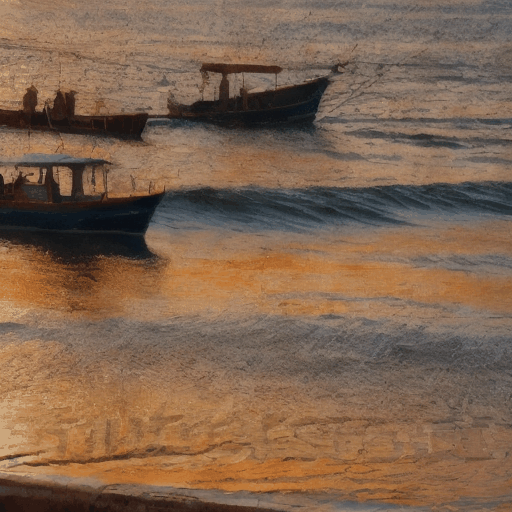

In [5]:
from IPython.display import Image
Image(open('animation.gif','rb').read())